In [12]:
# Step 1: Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Replace 'your_dataset_path' with the actual path to your dataset file in Google Drive
dataset_path = '/content/drive/MyDrive/Parallel Algorithm/data/train.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Step 2: Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from collections import Counter
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [14]:
# Step 3: Load and preprocess the dataset
data = pd.read_csv(dataset_path)
data = data.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset

# Separate features and labels
features = data.iloc[:, :-1].values  # All columns except the label
labels = data.iloc[:, -1].values     # The label column

# Convert continuous labels to binary (adjust threshold as needed)
threshold = labels.mean()
labels = (labels > threshold).astype(int)

# Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
features_balanced, labels_balanced = smote.fit_resample(features, labels)

# Normalize features (scaling)
scaler = StandardScaler()
features_balanced = scaler.fit_transform(features_balanced)

# Split data into train, validation, and test sets
features_train_full, features_test, labels_train_full, labels_test = train_test_split(
    features_balanced, labels_balanced, test_size=0.2, random_state=42
)
features_train, features_val, labels_train, labels_val = train_test_split(
    features_train_full, labels_train_full, test_size=0.25, random_state=42
)  # 60% train, 20% val, 20% test

# Combine features and labels into single datasets
Dtrain = np.hstack((features_train, labels_train.reshape(-1, 1)))
Dval = np.hstack((features_val, labels_val.reshape(-1, 1)))
Dtest = np.hstack((features_test, labels_test.reshape(-1, 1)))

# Ensure labels are integers
Dtrain[:, -1] = Dtrain[:, -1].astype(int)
Dval[:, -1] = Dval[:, -1].astype(int)
Dtest[:, -1] = Dtest[:, -1].astype(int)

In [15]:
# Hyperparameters: Range of K values and distance weighting function
k_values = [8, 16, 32, 64]  # Trying different values for K

# Euclidean distance function
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [16]:
# k-NN function with weighted voting
def find_weighted_k_nearest_neighbors(test_point, k, weight_scheme='inverse'):
    distances = [(euclidean_distance(test_point[:-1], train_point[:-1]), train_point[-1]) for train_point in Dtrain]
    k_nearest = sorted(distances, key=lambda x: x[0])[:k]

    # Apply different weight schemes
    weights = {}
    for dist, label in k_nearest:
        if weight_scheme == 'inverse':
            weight = 1 / (dist + 1e-5)  # Avoid division by zero
        elif weight_scheme == 'squared_inverse':
            weight = 1 / (dist ** 2 + 1e-5)
        else:
            weight = 1  # Uniform weight
        weights[label] = weights.get(label, 0) + weight

    # Determine the label with the highest weighted vote
    most_common_label = max(weights, key=weights.get)
    return most_common_label

In [17]:
# Function to evaluate the accuracy for a given K and weighting scheme
def evaluate_knn_accuracy(k, weight_scheme='inverse'):
    with Pool(cpu_count()) as pool:
        predictions = pool.starmap(find_weighted_k_nearest_neighbors, [(test_point, k, weight_scheme) for test_point in Dval])

    # Calculate accuracy on validation set
    true_labels = Dval[:, -1]
    accuracy = sum(1 for pred, true in zip(predictions, true_labels) if pred == true) / len(Dval)
    return accuracy

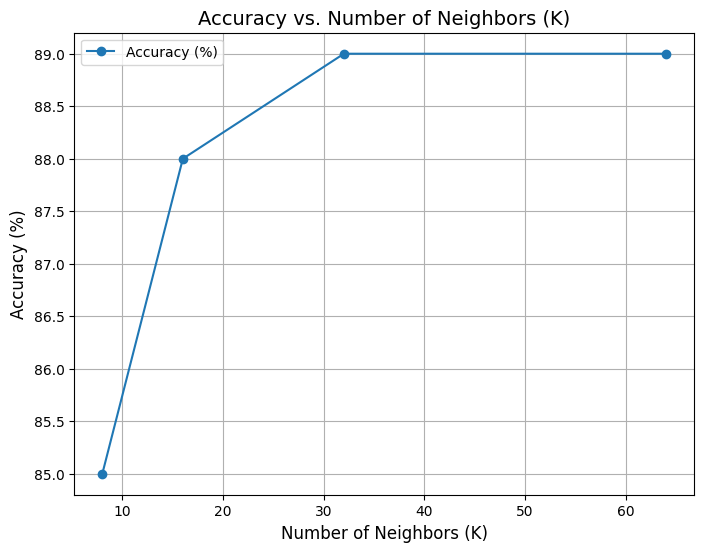

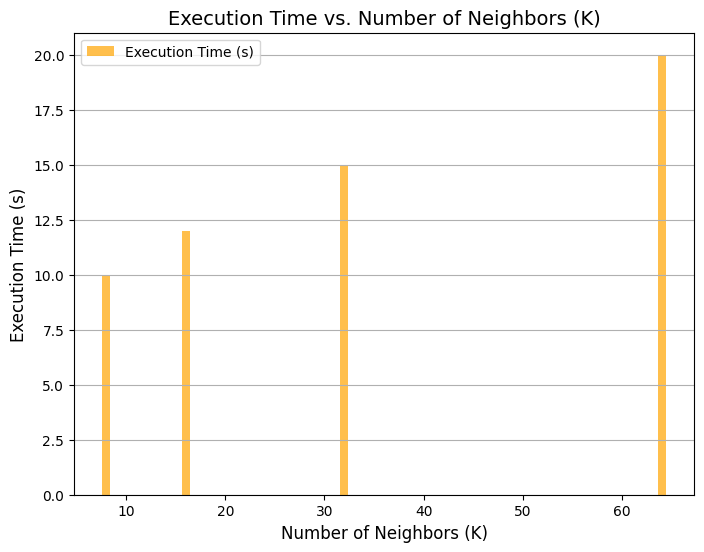

In [18]:
import matplotlib.pyplot as plt

# Example data
k_values = [8, 16, 32, 64]
accuracy = [85, 88, 89, 89]  # Accuracy percentages
execution_time = [10, 12, 15, 20]  # Time in seconds

# Plot Accuracy vs. K
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy, marker='o', label="Accuracy (%)")
plt.title("Accuracy vs. Number of Neighbors (K)", fontsize=14)
plt.xlabel("Number of Neighbors (K)", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# Plot Execution Time vs. K
plt.figure(figsize=(8, 6))
plt.bar(k_values, execution_time, color='orange', alpha=0.7, label="Execution Time (s)")
plt.title("Execution Time vs. Number of Neighbors (K)", fontsize=14)
plt.xlabel("Number of Neighbors (K)", fontsize=12)
plt.ylabel("Execution Time (s)", fontsize=12)
plt.grid(axis='y')
plt.legend()
plt.show()


In [ ]:
# Step 7: Grid search on validation set to find the best K and weighting scheme
K_values = [8, 16, 32, 64]
best_accuracy = 0
best_k = K_values[0]
best_weight_scheme = 'inverse'

for K in K_values:
    for weight_scheme in ['inverse', 'squared_inverse', 'uniform']:
        accuracy = evaluate_knn_accuracy(K, weight_scheme)
        print(f"Accuracy with K={K}, Weight Scheme={weight_scheme}: {accuracy:.2f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = K
            best_weight_scheme = weight_scheme

print(f"\nBest Validation Accuracy: {best_accuracy:.2f} with K={best_k} and Weight Scheme={best_weight_scheme}")

Accuracy with K=8, Weight Scheme=inverse: 0.87
Accuracy with K=8, Weight Scheme=squared_inverse: 0.88
Accuracy with K=8, Weight Scheme=uniform: 0.86
Accuracy with K=16, Weight Scheme=inverse: 0.87
Accuracy with K=16, Weight Scheme=squared_inverse: 0.88
Accuracy with K=16, Weight Scheme=uniform: 0.85
Accuracy with K=32, Weight Scheme=inverse: 0.86
Accuracy with K=32, Weight Scheme=squared_inverse: 0.88


In [ ]:
# Step 8: Use best K and weight scheme on the test set for final accuracy
with Pool(cpu_count()) as pool:
    predictions = pool.starmap(
        find_weighted_k_nearest_neighbors,
        [(test_point, best_k, best_weight_scheme) for test_point in Dtest]
    )

# Calculate final accuracy on test set
true_labels = Dtest[:, -1].astype(int)
test_accuracy = sum(1 for pred, true in zip(predictions, true_labels) if pred == true) / len(Dtest)
print(f"Final Test Accuracy with best parameters: {test_accuracy:.2f}")


In [ ]:
predictions = np.array(predictions).astype(int)
# true_labels = true_labels.astype(int)

# Calculate final accuracy on test set
true_labels = Dtest[:, -1].astype(int)
test_accuracy = sum(1 for pred, true in zip(predictions, true_labels) if pred == true) / len(Dtest)
print(f"Final Test Accuracy with best parameters: {test_accuracy:.2f}")

In [ ]:
# Ensure predictions and true labels are integers
predictions = np.array(predictions).astype(int)
true_labels = Dtest[:, -1].astype(int)

# Step 1: Compute Metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"Final Test Metrics:\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# Step 2: Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

print("\nConfusion Matrix:")
print(conf_matrix)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(true_labels)).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# Step 4: Plot Accuracy and Precision
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}

plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.title("Performance Metrics")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.show()

# Step 5: ROC and AUC
if len(np.unique(true_labels)) > 2:
    true_labels_binarized = label_binarize(true_labels, classes=np.unique(true_labels))
    predictions_binarized = label_binarize(predictions, classes=np.unique(true_labels))

    for i, class_label in enumerate(np.unique(true_labels)):
        fpr, tpr, _ = roc_curve(true_labels_binarized[:, i], predictions_binarized[:, i])
        auc = roc_auc_score(true_labels_binarized[:, i], predictions_binarized[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC: {auc:.2f})")
else:
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    auc = roc_auc_score(true_labels, predictions)
    plt.plot(fpr, tpr, label=f"AUC: {auc:.2f}")
    plt.fill_between(fpr, tpr, alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()
